In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 图像增广
:label:`sec_image_augmentation`

在 :numref:`sec_alexnet` 中，我们提到过大型数据集是成功应用深度神经网络的先决条件。
图像增广在对训练图像进行一系列的随机变化之后，生成相似但不同的训练样本，从而扩大了训练集的规模。
此外，应用图像增广的原因是，随机改变训练样本可以减少模型对某些属性的依赖，从而提高模型的泛化能力。
例如，我们可以以不同的方式裁剪图像，使感兴趣的对象出现在不同的位置，减少模型对于对象出现位置的依赖。
我们还可以调整亮度、颜色等因素来降低模型对颜色的敏感度。
可以说，图像增广技术对于AlexNet的成功是必不可少的。在本节中，我们将讨论这项广泛应用于计算机视觉的技术。


In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l


## 常用的图像增广方法

我们对常用图像增广方法的探索中，我们将使用下面这个尺寸为 $400\times 500$ 的图像作为示例。


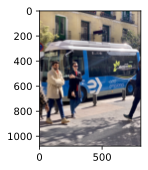

In [3]:
d2l.set_figsize()
img = d2l.Image.open('./bus.jpg')
d2l.plt.imshow(img);

大多数图像增广方法都具有一定的随机性。为了便于观察图像增广的效果，我们下面定义辅助函数 `apply` 。
此函数在输入图像 `img` 上多次运行图像增广方法 `aug` 并显示所有结果。


In [4]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

### 翻转和裁剪

[**左右翻转图像**]通常不会改变对象的类别。这是最早和最广泛使用的图像增广方法之一。
接下来，我们使用 `transforms` 模块来创建 `RandomFlipLeftRight` 实例，这样就各有50%的几率使图像向左或向右翻转。


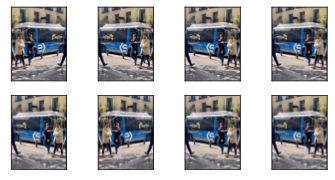

In [5]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

[**上下翻转图像**]不如左右图像翻转那样常用。但是，至少对于这个示例图像，上下翻转不会妨碍识别。接下来，我们创建一个 `RandomFlipTopBottom` 实例，使图像各有50%的几率向上或向下翻转。


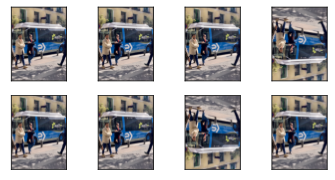

In [6]:
apply(img, torchvision.transforms.RandomVerticalFlip())

在我们使用的示例图像中，猫位于图像的中间，但并非所有图像都是这样。
在 :numref:`sec_pooling` 中，我们解释了汇聚层可以降低卷积层对目标位置的敏感性。
另外，我们可以通过对图像进行随机裁剪，使物体以不同的比例出现在图像的不同位置。
这也可以降低模型对目标位置的敏感性。

在下面的代码中，我们[**随机裁剪**]一个面积为原始面积10%到100%的区域，该区域的宽高比从0.5到2之间随机取值。
然后，区域的宽度和高度都被缩放到200像素。
在本节中（除非另有说明），$a$和$b$之间的随机数指的是在区间$[a, b]$中通过均匀采样获得的连续值。


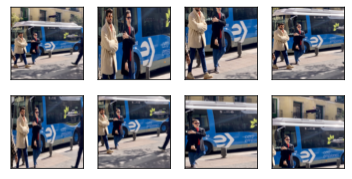

In [7]:
# 原始面积10%到100%的区域，该区域的宽高比从0.5到2之间随机取值，输出为(200,200)
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### 改变颜色

另一种增广方法是改变颜色。
我们可以改变图像颜色的四个方面：亮度、对比度、饱和度和色调。
在下面的示例中，我们[**随机更改图像的亮度**]，随机值为原始图像的50%（$1-0.5$）到150%（$1+0.5$）之间。


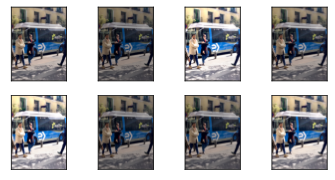

In [8]:
apply(
    img,
    torchvision.transforms.ColorJitter(brightness=0.5, contrast=0,
                                       saturation=0, hue=0))

同样，我们可以[**随机更改图像的色调**]。


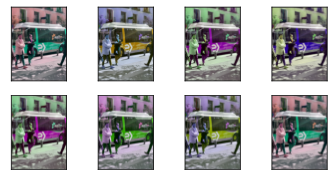

In [9]:
apply(
    img,
    torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0,
                                       hue=0.5))

我们还可以创建一个 `RandomColorJitter` 实例，并设置如何同时[**随机更改图像的亮度（`brightness`）、对比度（`contrast`）、饱和度（`saturation`）和色调（`hue`）**]。


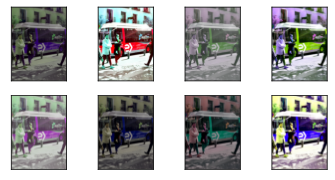

In [10]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5,
                                               saturation=0.5, hue=0.5)
apply(img, color_aug)

### [**结合多种图像增广方法**]

在实践中，我们将结合多种图像增广方法。比如，我们可以通过使用一个 `Compose` 实例来综合上面定义的不同的图像增广方法，并将它们应用到每个图像。


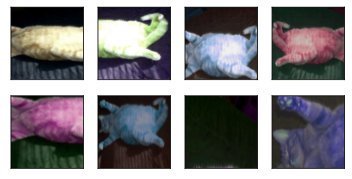

In [ ]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

## [**使用图像增广进行训练**]

让我们使用图像增广来训练模型。
这里，我们使用CIFAR-10数据集，而不是我们之前使用的Fashion-MNIST数据集。
这是因为Fashion-MNIST数据集中对象的位置和大小已被规范化，而CIFAR-10数据集中对象的颜色和大小差异更明显。
CIFAR-10数据集中的前32个训练图像如下所示。


In [12]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=False)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

RuntimeError: Dataset not found or corrupted. You can use download=True to download it

使用本地的cifar

In [24]:
import os
data_dir = "../data/cifar-10/"
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=train_augs) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=test_augs) for folder in ['valid', 'test']]


为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，且在预测过程中不使用随机操作的图像增广。
在这里，我们[**只使用最简单的随机左右翻转**]。
此外，我们使用 `ToTensor` 实例将一批图像转换为深度学习框架所要求的格式，即形状为（批量大小，通道数，高度，宽度）的32位浮点数，取值范围为0到1。


In [13]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

接下来，我们[**定义一个辅助函数，以便于读取图像和应用图像增广**]。PyTorch 数据集提供的 `transform` 函数应用图像增广来转化图像。有关 `DataLoader` 的详细介绍，请参阅 :numref:`sec_fashion_mnist` 。


In [ ]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train,
        num_workers=d2l.get_dataloader_workers())
    return dataloader

### 多GPU训练

我们在CIFAR-10数据集上训练 :numref:`sec_resnet` 中的ResNet-18模型。
回想一下 :numref:`sec_multi_gpu_concise` 中对多 GPU 训练的介绍。
接下来，我们[**定义一个函数，使用多GPU对模型进行训练和评估**]。


In [28]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        # 微调BERT中所需（稍后讨论）
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [29]:
#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer,
                                      devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

现在，我们可以[**定义 `train_with_data_aug` 函数，使用图像增广来训练模型**]。该函数获取所有的GPU，并使用Adam作为训练的优化算法，将图像增广应用于训练集，最后调用刚刚定义的用于训练和评估模型的 `train_ch13` 函数。


In [34]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

# 原先的
# def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
#     train_iter = load_cifar10(True, train_augs, batch_size)
#     test_iter = load_cifar10(False, test_augs, batch_size)
#     loss = nn.CrossEntropyLoss(reduction="none")
#     trainer = torch.optim.Adam(net.parameters(), lr=lr)
#     train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = data.DataLoader(train_augs,batch_size=batch_size,shuffle=True,)

    test_iter = data.DataLoader(test_augs,batch_size=batch_size,shuffle=True,)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

让我们使用基于随机左右翻转的图像增广来[**训练模型**]。


In [ ]:
from torch.utils import data
train_with_data_aug(train_ds, train_valid_ds, net)

## 小结

* 图像增广基于现有的训练数据生成随机图像，来提高模型的概化能力。
* 为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，而在预测过程中不使用随机操作的图像增广。
* 深度学习框架提供了许多不同的图像增广方法，这些方法可以被同时应用。

## 练习

1. 在不使用图像增广的情况下训练模型： `train_with_data_aug(no_aug, no_aug)` 。比较使用和不使用图像增广的训练结果和测试精度。这个对比实验能支持图像增广可以减轻过度拟合的论点吗？为什么？
2. 在基于 CIFAR-10 数据集的模型训练中结合多种不同的图像增广方法。它能提高测试准确性吗？
3. 参阅深度学习框架的在线文档。它还提供了哪些其他的图像增广方法？


# 微调
:label:`sec_fine_tuning`

在前面的一些章节中，我们介绍了如何在只有6万张图像的Fashion-MNIST训练数据集上训练模型。
我们还描述了学术界当下使用最广泛的大规模图像数据集ImageNet，它有超过1,000万的图像和1,000类的物体。
然而，我们平常接触到的数据集的规模通常在这两者之间。

假设我们想识别图片中不同类型的椅子，然后向用户推荐购买链接。
一种可能的方法是首先识别 100 把普通椅子，为每把椅子拍摄 1000 张不同角度的图像，然后在收集的影像数据集上训练一个分类模型。
尽管这个椅子数据集可能大于 Fashion-MNIST 数据集，但实例数量仍然不到 ImageNet 中的十分之一。
这可能会导致这个椅子数据集上适合 ImageNet 的复杂模型过度拟合。
此外，由于训练示例数量有限，训练模型的准确性可能无法满足实际要求。 

为了解决上述问题，一个显而易见的解决方案是收集更多的数据。
但是，收集和标记数据可能需要大量的时间和金钱。
例如，为了收集 ImageNet 数据集，研究人员从研究资金中花费了数百万美元。
尽管目前的数据收集成本已大幅降低，但这一成本仍不能忽视。 

另一种解决方案是应用 *迁移学习*（transfer learning） 将从 *源数据集* 学到的知识迁移到 *目标数据集*。
例如，尽管 ImageNet 数据集中的大多数图像与椅子无关，但在此数据集上训练的模型可能会提取更常规的图像特征，这有助于识别边缘、纹理、形状和对象合成。
这些类似的功能也可能有效地识别椅子。 

## 步骤

在本节中，我们将介绍迁移学习中的常见技巧 : *微调*（fine-tuning）。如 :numref:`fig_finetune` 所示，微调包括以下四个步骤： 

1. 在源数据集（例如 ImageNet 数据集）上预训练神经网络模型，即 *源模型*。
1. 创建一个新的神经网络模型，即 *目标模型*。这将复制源模型上的所有模型设计及其参数，但输出层除外。我们假定这些模型参数包含从源数据集中学到的知识，这些知识也将适用于目标数据集。我们还假设源模型的输出图层与源数据集的标签密切相关；因此不在目标模型中使用该图层。
1. 向目标模型添加输出图层，其输出数量是目标数据集中的类别数。然后随机初始化该层的模型参数。
1. 在目标数据集（如椅子数据集）上训练目标模型。输出图层将从头开始进行训练，而所有其他图层的参数将根据源模型的参数进行微调。

![微调。](http://d2l.ai/_images/finetune.svg)
:label:`fig_finetune`

当目标数据集比源数据集小得多时，微调有助于提高模型的泛化能力。 

## 热狗识别

让我们通过具体案例演示微调：热狗识别。
我们将在一个小型数据集上微调 ResNet 模型，该数据集已在 ImageNet 数据集上进行了预训练。
这个小型数据集包含数千张包含热狗和不包含热狗的图像，我们将使用微调模型来识别图像中是否包含热狗。


In [36]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

### 获取数据集

我们使用的[**热狗数据集来源于网络**]。该数据集包含 1400 张包含热狗的正面类图像以及包含其他食物的尽可能多的负面级图像。两个类别的 1000 张图片用于训练，其余的则用于测试。 

解压下载的数据集后，我们获得了两个文件夹 `hotdog/train` 和 `hotdog/test`。这两个文件夹都有 `hotdog` 和 `not-hotdog` 个子文件夹，其中任何一个文件夹都包含相应类的图像。


In [2]:
#@save
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                          'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

构造两个数据集类来分别读取训练和测试数据集中的所有图像文件。


In [37]:
data_dir = "../data/hotdog/"
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

下面显示了前 8 个正面示例和最后 8 张负面图片。
正如你所看到的，[**图像的大小和纵横比各有不同**]。


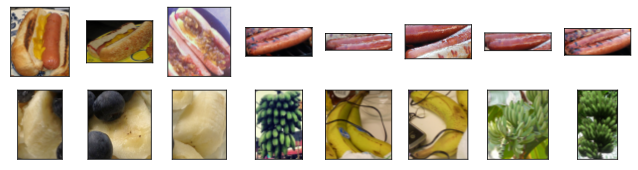

In [38]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [46]:
import numpy as np
np.asarray(hotdogs[0]).shape

(144, 122, 3)

在训练期间，我们首先从图像中裁切随机大小和随机长宽比的区域，然后将该区域缩放为 $224 \times 224$ 输入图像。
在测试过程中，我们将图像的高度和宽度都缩放到 256 像素，然后裁剪中央 $224 \times 224$ 区域作为输入。
此外，对于三个 RGB（红、绿和蓝）颜色通道，我们 *标准化* 每个通道。
具体而言，通道的平均值将从该通道的每个值中减去，然后将结果除以该通道的标准差。

[~~数据增广~~]


In [47]:
# 使用三个RGB通道的均值和标准偏差，以标准化每个通道
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),   # 随机裁剪并缩放
    torchvision.transforms.RandomHorizontalFlip(),   # 随机水平翻转
    torchvision.transforms.ToTensor(), normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),           # 中央裁剪
    torchvision.transforms.ToTensor(), normalize])

### [**定义和初始化模型**]

我们使用在 ImageNet 数据集上预训练的 Resnet-18 作为源模型。
在这里，我们指定 `pretrained=True` 以自动下载预训练的模型参数。
如果你首次使用此模型，则需要互联网连接才能下载。


In [49]:
pretrained_net = torchvision.models.resnet18(pretrained=True,progress=True)

In [51]:
pretrained_net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

预训练的源模型实例包含许多要素图层和一个输出图层 `fc`。
此划分的主要目的是促进对除输出层以外所有层的模型参数进行微调。
下面给出了源模型的变量 `fc`。


In [50]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

在 ResNet 的全局平均池化后，完全连接的层汇集转换为 ImageNet 数据集的 1000 个类输出。
之后，我们构建一个新的神经网络作为目标模型。
它的定义方式与预训练源模型的定义方式相同，只是最终图层中的输出数量被设置为目标数据集中的类数（而不是1000个）。 

在下面的代码中，目标模型实例 `finetune_net` 的变量特征中的模型参数被初始化为源模型相应层的模型参数。
由于功能中的模型参数是在 ImageNet 数据集上预训练的，并且足够好，因此通常只需要较小的学习率即可微调这些参数。  

变量输出中的模型参数是随机初始化的，通常需要更高的学习率才能从头开始训练。
假设 `Trainer` 实例中的学习率为，我们将迭代中变量输出中模型参数的学习率设置为 10。 

在下面的代码中，初始化目标模型实例 `finetune_net` 输出层之前的模型参数，以对源模型中相应层的参数进行建模。
由于这些模型参数是通过 ImageNet 上的预训练获得的，因此它们很有效，
所以我们只需使用较小的学习率进行 *微调* 这样的预训练参数。
相比之下，输出层中的模型参数是随机初始化的，通常需要更高的学习率，从头开始学习。
这里，我们设基本学习率为 $\eta$，迭代输出层学习率为 $10\eta$。


In [52]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
# 将输出层权重初始化
nn.init.xavier_uniform_(finetune_net.fc.weight);

### [**微调模型**]

首先，我们定义了一个训练函数 `train_fine_tuning`，该函数使用微调，因此可以多次调用。


**输出层中的模型参数是随机初始化的，通常需要更高的学习率**

In [53]:
# 如果 `param_group=True`，输出层中的模型参数将使用十倍的学习率
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                         transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'),
                                         transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        # params_1x中存放的是所有非输出层的参数
        params_1x = [
            param for name, param in net.named_parameters()
            if name not in ["fc.weight", "fc.bias"]]
        # 对输出层特别指定学习率
        trainer = torch.optim.SGD([{
            'params': params_1x}, {
                'params': net.fc.parameters(),
                'lr': learning_rate * 10}], lr=learning_rate,
                                  weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

我们[**使用较小的学习率**]，通过*微调*预训练获得的模型参数。


loss 0.248, train acc 0.909, test acc 0.920
673.2 examples/sec on [device(type='cuda', index=0)]


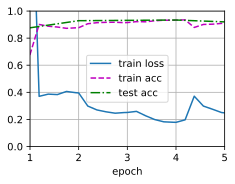

In [54]:
train_fine_tuning(finetune_net, 5e-5)

[**为了进行比较，**]我们定义了一个相同的模型，但是将其(**所有模型参数初始化为随机值**)。
由于整个模型需要从头开始训练，因此我们需要使用更大的学习率。


loss 0.369, train acc 0.846, test acc 0.819
676.3 examples/sec on [device(type='cuda', index=0)]


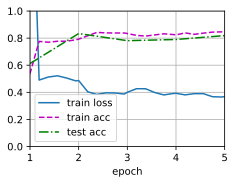

In [55]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

意料之中，微调模型往往表现更好，因为它的初始参数值更有效。 

## 小结

* 迁移学习将从源数据集中学到的知识“迁移”到目标数据集，微调是迁移学习的常见技巧。
* 除输出层外，目标模型从源模型中复制所有模型设计及其参数，并根据目标数据集对这些参数进行微调。但是，目标模型的输出层需要从头开始训练。
* 通常，微调参数使用较小的学习率，而从头开始训练输出层可以使用更大的学习率。

## 练习

1. 继续提高 `finetune_net` 的学习率，模型的准确性如何变化？
2. 在比较实验中进一步调整 `finetune_net` 和 `scratch_net` 的超参数。它们的准确性还有不同吗？
3. 将输出层 `finetune_net` 之前的参数设置为源模型的参数，在训练期间不要更新它们。模型的准确性如何变化？你可以使用以下代码。


In [ ]:
for param in finetune_net.parameters():
    param.requires_grad = False

4. 事实上，`ImageNet` 数据集中有一个 “热狗” 类。我们可以通过以下代码获取其输出层中的相应权重参数，但是我们怎样才能利用这个权重参数？


In [ ]:
weight = pretrained_net.fc.weight
hotdog_w = torch.split(weight.data, 1, dim=0)[713]
hotdog_w.shape

torch.Size([1, 512])

# 目标检测和边界框
:label:`sec_bbox`

在前面的章节（例如 :numref:`sec_alexnet`—:numref:`sec_googlenet`）中，我们介绍了各种图像分类模型。
在图像分类任务中，我们假设图像中只有一个主要物体对象，我们只关注如何识别其类别。
然而，很多时候图像里有多个我们感兴趣的目标，我们不仅想知道它们的类别，还想得到它们在图像中的具体位置。
在计算机视觉里，我们将这类任务称为*目标检测*（object detection）或*物体检测*。

目标检测在多个领域中被广泛使用。
例如，在无人驾驶里，我们需要通过识别拍摄到的视频图像里的车辆、行人、道路和障碍的位置来规划行进线路。
机器人也常通过该任务来检测感兴趣的目标。安防领域则需要检测异常目标，如歹徒或者炸弹。



在接下来的几节中，我们将介绍几种用于目标检测的深度学习方法。
我们将首先介绍对象的*位置*。


In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

下面加载本节将使用的示例图像。可以看到图像左边是一只狗，右边是一只猫。
它们是这张图像里的两个主要目标。


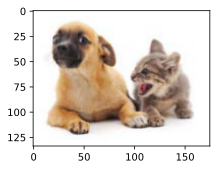

In [3]:
d2l.set_figsize()
img = d2l.plt.imread('../img/catdog.jpg')
d2l.plt.imshow(img);

## 边界框

在目标检测中，我们通常使用*边界框*（bounding box）来描述对象的空间位置。
边界框是矩形的，由矩形左上角的 $x$ 和 $y$ 坐标以及右下角的坐标决定。
另一种常用的边界框表示方法是边界框中心的 $(x, y)$ 轴坐标以及框的宽度和高度。 

在这里，我们[**定义在这两种表示之间进行转换的函数**]：`box_corner_to_center` 从两角表示转换为中心宽度表示，而 `box_center_to_corner` 反之亦然。
输入参数 `boxes` 可以是长度为 4 的张量，也可以是形状的二维张量（$n$，4），其中 $n$ 是边界框的数量。


In [4]:
#@save
def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间，宽度，高度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

#@save
def box_center_to_corner(boxes):
    """从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

我们将根据坐标信息[**定义图像中狗和猫的边界框**]。
图像中坐标的原点是图像的左上角，右侧和向下分别是 $x$ 和 $y$ 轴的正方向。


In [5]:
# bbox是边界框的英文缩写
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

我们可以通过转换两次来验证两个边界框转换函数的正确性。


In [6]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

我们可以[**将边界框在图中画出**]，以检查其是否准确。
画之前，我们定义一个辅助函数 `bbox_to_rect`。
它将边界框表示成 `matplotlib` 的边界框格式。


In [7]:
#@save
def bbox_to_rect(bbox, color):
    # 将边界框 (左上x, 左上y, 右下x, 右下y) 格式转换成 matplotlib 格式：
    # ((左上x, 左上y), 宽, 高)
    return d2l.plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2] - bbox[0],
                             height=bbox[3] - bbox[1], fill=False,
                             edgecolor=color, linewidth=2)

在图像上添加边界框之后，我们可以看到两个物体的主要轮廓基本上在两个框内。


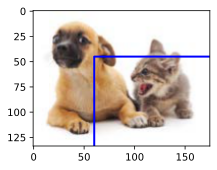

In [8]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

## 小结

* 目标检测不仅可以识别图像中所有感兴趣的物体，还能识别它们的位置，该位置通常由矩形边界框表示。
* 我们可以在两种常用的边界框表示（中间，宽度，高度）和（左上，右下）坐标之间进行转换。

## 练习

1. 找到另一张图像，然后尝试标记包含该对象的边界框。比较标签边界框和类别：哪些通常需要更长时间？
1. 为什么 `box_corner_to_center` 和 `box_center_to_corner` 的输入参数的最内层维度总是4？


# 锚框
:label:`sec_anchor`

目标检测算法通常会在输入图像中采样大量的区域，然后判断这些区域中是否包含我们感兴趣的目标，并调整区域边缘从而更准确地预测目标的*真实边界框*（ground-truth bounding box）。
不同的模型使用的区域采样方法可能不同。
这里我们介绍其中的一种方法：它以每个像素为中心生成多个大小和宽高比（aspect ratio）不同的边界框。
这些边界框被称为*锚框*（anchor box）我们将在 :numref:`sec_ssd` 中基于锚框设计一个目标检测模型。 

首先，让我们修改打印精度，以获得更简洁的输出。


In [9]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)  # 精简打印精度


## 生成多个锚框

假设输入图像的高度为 $h$，宽度为 $w$。
我们以图像的每个像素为中心生成不同形状的锚框：*比例* 为 $s\in (0, 1]$，*宽高比*（宽高比）为 $r > 0$。
那么[**锚框的宽度和高度分别是 $ws\sqrt{r}$ 和 $hs/\sqrt{r}$。**]
请注意，当中心位置给定时，已知宽和高的锚框是确定的。 

要生成多个不同形状的锚框，让我们设置一系列刻度 $s_1,\ldots, s_n$ 和一系列宽高比 $r_1,\ldots, r_m$。
当使用这些比例和长宽比的所有组合以每个像素为中心时，输入图像将总共有 $whnm$ 个锚框。
尽管这些锚框可能会覆盖所有地面真实边界框，但计算复杂性很容易过高。
在实践中，(**我们只考虑**)包含 $s_1$ 或 $r_1$ 的(**组合：**)

(**
$$(s_1, r_1), (s_1, r_2), \ldots, (s_1, r_m), (s_2, r_1), (s_3, r_1), \ldots, (s_n, r_1).$$
**)

也就是说，以同一像素为中心的锚框的数量是 $n+m-1$。
对于整个输入图像，我们将共生成 $wh(n+m-1)$ 个锚框。 

上述生成锚框的方法可以在以下 `multibox_prior` 函数中实现。
我们指定输入图像、尺度列表和宽高比列表，然后此函数将返回所有的锚框。


In [10]:
#@save
def multibox_prior(data, sizes, ratios):
    """生成以每个像素为中心具有不同形状的锚框。"""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    # 为了将锚点移动到像素的中心，需要设置偏移量。
    # 因为一个像素的的高为1且宽为1，我们选择偏移我们的中心0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # 生成锚框的所有中心点
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # 生成“boxes_per_pixel”个高和宽，
    # 之后用于创建锚框的四角坐标 (xmin, xmax, ymin, ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # Handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # 除以2来获得半高和半宽
    anchor_manipulations = torch.stack(
        (-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2

    # 每个中心点都将有“boxes_per_pixel”个锚框，
    # 所以生成含所有锚框中心的网格，重复了“boxes_per_pixel”次
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                           dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

我们可以看到[**返回的锚框变量 `Y` 的形状**]是（批量大小，锚框的数量，4）。


In [11]:
img = d2l.plt.imread('../img/catdog.jpg')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

134 175


torch.Size([1, 117250, 4])

将锚框变量 `Y` 的形状更改为（图像高度、图像宽度、以同一像素为中心的锚框的数量，4）后，我们就可以获得以指定像素的位置为中心的所有锚框了。
在接下来的内容中，我们[**访问以 (250, 250) 为中心的第一个锚框**]。
它有四个元素：锚框左上角的 $(x, y)$ 轴坐标和右下角的 $(x, y)$ 轴坐标。
将两个轴的坐标分别除以图像的宽度和高度后，所得的值就介于 0 和 1 之间。


In [12]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

IndexError: index 250 is out of bounds for dimension 0 with size 134

为了[**显示以图像中一个像素为中心的所有锚框**]，我们定义了以下 `show_bboxes` 函数来在图像上绘制多个边界框。


In [ ]:
#@save
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框。"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i], va='center',
                      ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

正如我们刚才看到的，变量 `boxes` 中 $x$ 轴和 $y$ 轴的坐标值已分别除以图像的宽度和高度。
绘制锚框时，我们需要恢复它们原始的坐标值。
因此，我们在下面定义了变量 `bbox_scale` 。
现在，我们可以绘制出图像中所有以（250、250）为中心的锚框了。
如下所示，尺度为 0.75 且宽高比为 1 的蓝色锚框很好地围绕着图像中的狗。


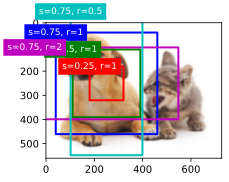

In [ ]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale, [
    's=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2', 's=0.75, r=0.5'
])

## [**交并比(IoU)**]

我们刚刚提到某个锚框“较好地”覆盖了图像中的狗。
如果已知目标的真实边界框，那么这里的 “好”该如何如何量化呢？
直观地说，我们可以衡量锚框和真实边界框之间的相似性。
我们知道 *Jaccard 系数* 可以衡量两组之间的相似性。
给定集合 $\mathcal{A}$ 和 $\mathcal{B}$，他们的 Jaccard 系数是他们交集的大小除以他们并集的大小：  

$$J(\mathcal{A},\mathcal{B}) = \frac{\left|\mathcal{A} \cap \mathcal{B}\right|}{\left| \mathcal{A} \cup \mathcal{B}\right|}.$$

事实上，我们可以将任何边界框的像素区域视为一组像素。通
过这种方式，我们可以通过其像素集的 Jaccard 索引来测量两个边界框的相似性。
对于两个边界框，我们通常将他们的 Jaccard 指数称为 *交并比* (intersection over union，IoU)，即两个边界框相交面积与相并面积之比，如 :numref:`fig_iou` 所示。
交并比的取值范围在0和1之间：0表示两个边界框无重合像素，1表示两个边界框完全重合。 

![交并比是两个边界框相交面积与相并面积之比。](http://d2l.ai/_images/iou.svg)
:label:`fig_iou`

在接下来部分中，我们将使用交并比来衡量锚框和真实边界框之间、以及不同锚框之间的相似度。
给定两个锚框或边界框的列表，以下 `box_iou` 函数将在这两个列表中计算它们成对的交并比。


In [ ]:
#@save
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比。"""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # `boxes1`, `boxes2`, `areas1`, `areas2`的形状:
    # `boxes1`：(boxes1的数量, 4),
    # `boxes2`：(boxes2的数量, 4),
    # `areas1`：(boxes1的数量,),
    # `areas2`：(boxes2的数量,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    #  `inter_upperlefts`, `inter_lowerrights`, `inters`的形状:
    # (boxes1的数量, boxes2的数量, 2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # `inter_areas` and `union_areas`的形状: (boxes1的数量, boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

## 标注训练数据的锚框
:label:`subsec_labeling-anchor-boxes`

在训练集中，我们将每个锚框视为一个训练样本。
为了训练目标检测模型，我们需要每个锚框的类别（class）和偏移量（offset）标签，其中前者是与锚框相关的对象的类别，后者是真实边界框相对于锚框的偏移量。
在预测期间，我们为每个图像生成多个锚框，预测所有锚框的类和偏移量，根据预测的偏移量调整它们的位置以获得预测的边界框，最后只输出符合特定条件的预测边界框。 

我们知道，目标检测训练集附带了“真实边界框”的位置及其包围物体类别的标签。
要标记任何生成的锚框，我们可以参考“分配到的”最接近此锚框的真实边界框的位置和类别标签。
在下文中，我们将介绍把最接近的真实边界框分配给锚框的算法。 

### [**将真实边界框分配给锚框**]

给定图像，假设锚框是 $A_1, A_2, \ldots, A_{n_a}$，真实边界框是 $B_1, B_2, \ldots, B_{n_b}$，其中 $n_a \geq n_b$。
让我们定义一个矩阵 $\mathbf{X} \in \mathbb{R}^{n_a \times n_b}$，其中 $i^\mathrm{th}$ 行和 $j^\mathrm{th}$ 列中的元素 $x_{ij}$ 是锚框 $A_i$ 和真实边界框 $B_j$的 IoU 。
该算法包含以下步骤：

1. 在矩阵 $\mathbf{X}$ 中找到最大的元素，并将它的行索引和列索引分别表示为 $i_1$ 和 $j_1$。然后将真实边界框 $B_{j_1}$ 分配给锚框 $A_{i_1}$。这很直观，因为 $A_{i_1}$ 和 $B_{j_1}$ 是所有锚框和真实边界框配对中最相近的。在第一个分配完成后，丢弃矩阵中 ${i_1}^\mathrm{th}$ 行和 ${j_1}^\mathrm{th}$ 列中的所有元素。 
1. 在矩阵 $\mathbf{X}$ 中找到剩余元素中最大的元素，并将它的行索引和列索引分别表示为 $i_2$ 和 $j_2$。我们将真实边界框 $B_{j_2}$ 分配给锚框 $A_{i_2}$ ，并丢弃矩阵中 ${i_2}^\mathrm{th}$ 行和 ${j_2}^\mathrm{th}$ 列中的所有元素。
1. 此时，矩阵 $\mathbf{X}$ 中两行和两列中的元素已被丢弃。我们继续，直到丢弃掉矩阵 $\mathbf{X}$ 中 $n_b$ 列中的所有元素。此时，我们已经为这 $n_b$ 个锚框各自分配了一个真实边界框。
1. 只遍历剩下的 $n_a - n_b$ 个锚框。例如，给定任何锚框 $A_i$，在矩阵 $\mathbf{X}$ 的第 $i^\mathrm{th}$ 行中找到与 $A_i$ 的IoU最大 的真实边界框 $B_j$ ，只有当此 IoU 大于预定义的阈值时，才将 $B_j$ 分配给 $A_i$。


让我们用一个具体的例子来说明上述算法。
如 :numref:`fig_anchor_label`（左）所示，假设矩阵 $\mathbf{X}$ 中的最大值为 $x_{23}$，我们将真实边界框 $B_3$ 分配给锚框 $A_2$。
然后，我们丢弃矩阵第 2 行和第 3 列中的所有元素，在剩余元素（阴影区域）中找到最大的 $x_{71}$，然后将真实边界框 $B_1$ 分配给锚框 $A_7$。
接下来，如 :numref:`fig_anchor_label`（中）所示，丢弃矩阵第 7 行和第 1 列中的所有元素，在剩余元素（阴影区域）中找到最大的 $x_{54}$，然后将真实边界框 $B_4$ 分配给锚框 $A_5$。
最后，如 :numref:`fig_anchor_label`（右）所示，丢弃矩阵第 5 行和第 4 列中的所有元素，在剩余元素（阴影区域）中找到最大的 $x_{92}$，然后将真实边界框 $B_2$ 分配给锚框 $A_9$。
之后，我们只需要遍历剩余的锚框 $A_1, A_3, A_4, A_6, A_8$，然后根据阈值确定是否为它们分配真实边界框。  

![将真实边界框分配给锚框。](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/anchor-label.svg?raw=1)
:label:`fig_anchor_label`

此算法在以下 `assign_anchor_to_bbox` 函数中实现。


In [ ]:
#@save
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边界框分配给锚框。"""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 位于第i行和第j列的元素 x_ij 是锚框i和真实边界框j的IoU
    jaccard = box_iou(anchors, ground_truth)
    # 对于每个锚框，分配的真实边界框的张量
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # 根据阈值，决定是否分配真实边界框
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1)
    box_j = indices[max_ious >= 0.5]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

### 标记类和偏移

现在我们可以为每个锚框标记分类和偏移量了。
假设一个锚框 $A$ 被分配了一个真实边界框 $B$。
一方面，锚框 $A$ 的类将被标记为与 $B$ 相同。
另一方面，锚框 $A$ 的偏移量将根据 $B$ 和 $A$ 中心坐标的相对位置、以及这两个框的相对大小进行标记。
鉴于数据集内不同的框的位置和大小不同，我们可以对那些相对位置和大小应用变换，使其获得更均匀分布、易于适应的偏移量。
在这里，我们介绍一种常见的变换。
[**给定框 $A$ 和 $B$，中心坐标分别为 $(x_a, y_a)$ 和 $(x_b, y_b)$，宽度分别为 $w_a$ 和 $w_b$，高度分别为 $h_a$ 和 $h_b$。
我们可以将 $A$ 的偏移量标记为  

$$\left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x},
\frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right),$$
**]
其中常量的默认值是 $\mu_x = \mu_y = \mu_w = \mu_h = 0, \sigma_x=\sigma_y=0.1$ 和 $\sigma_w=\sigma_h=0.2$。
这种转换在下面的 `offset_boxes` 函数中实现。


In [ ]:
#@save
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换。"""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

如果一个锚框没有被分配真实边界框，我们只需将锚框的类标记为 “背景”类。
背景类的锚框通常被称为“负类”锚框，其余的被称为“正类”锚框。
我们使用真实边界框（ `labels` 参数）实现以下 `multibox_target` 函数，来[**标记锚框的类和偏移量**]（ `anchors` 参数）。
此函数将背景类设置为零，然后将新类的整数索引递增一。


In [ ]:
#@save
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框。"""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors,
                                                 device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # 将类标签和分配的边界框坐标初始化为零
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # 使用真实边界框来标记锚框的类别。
        # 如果一个锚框没有被分配，我们标记其为背景（值为零）
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # 偏移量转换
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

### 一个例子

让我们通过一个具体的例子来说明锚箱标签。
我们在加载的图像中为狗和猫定义了地面真实边界框，其中第一个元素是类（0 代表狗，1 代表猫），其余四个元素是左上角和右下角的 $(x, y)$ 轴坐标（范围介于 0 和 1 之间）。
我们还构建了五个锚框，用左上角和右下角的坐标进行标记：$A_0, \ldots, A_4$（索引从 0 开始）。
然后我们[**在图像中绘制这些地面真相边界框和锚框**]。


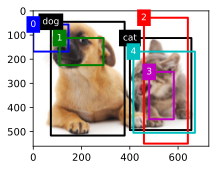

In [ ]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                             [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                        [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                        [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

使用上面定义的 `multibox_target` 函数，我们可以[**根据狗和猫的真实边界框，标注这些锚框的分类和偏移量**]。
在这个例子中，背景、狗和猫的类索引分别为 0、1 和 2。
下面我们为锚框和真实边界框范例添加了维度。


In [ ]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))

返回的结果中有三个元素，都是张量格式。第三个元素包含标记的输入锚框的类。 

让我们根据图像中的锚框和真实边界框的位置来分析下面返回的类标签。
首先，在所有的锚框和真实边界框配对中，锚框 $A_4$ 与猫的真实边界框的 IoU 是最大的。
因此，$A_4$ 的类被标记为猫。
去除包含 $A_4$ 或猫的真实边界框的配对，在剩下的配对中，锚框 $A_1$ 和狗的真实边界框有最大的 IoU。
因此，$A_1$ 的类被标记为狗。
接下来，我们需要遍历剩下的三个未标记的锚框：$A_0$、$A_2$ 和 $A_3$。
对于 $A_0$，与其拥有最大 IoU 的真实边界框的类是狗，但 IoU 低于预定义的阈值 (0.5)，因此该类被标记为背景；
对于$A_2$，与其拥有最大 IoU 的真实边界框的类是猫，IoU 超过阈值，所以类被标记为猫；
对于 $A_3$，与其拥有最大 IoU 的真实边界框的类是猫，但值低于阈值，因此该类被标记为背景。


In [ ]:
labels[2]

tensor([[0, 1, 2, 0, 2]])

返回的第二个元素是掩码（mask）变量，形状为（批量大小，锚框数的四倍）。
掩码变量中的元素与每个锚框的4个偏移量一一对应。
由于我们不关心对背景的检测，负类的偏移量不应影响目标函数。
通过元素乘法，掩码变量中的零将在计算目标函数之前过滤掉负类偏移量。


In [ ]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

返回的第一个元素包含了为每个锚框标记的四个偏移值。
请注意，负类锚框的偏移量被标记为零。


In [ ]:
labels[0]

tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
          2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
          4.17e-06,  6.26e-01]])

## 使用非极大值抑制预测边界框
:label:`subsec_predicting-bounding-boxes-nms`

在预测期间，我们先为图像生成多个锚框，再为这些锚框一一预测类别和偏移量。
一个“预测好的边界框”就根据带有预测偏移量的锚框就油然而生。
下面我们实现了 `offset_inverse` 函数，该函数将锚框和偏移量预测作为输入，并[**应用逆偏移变换来返回预测的边界框坐标**]。


In [ ]:
#@save
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框。"""
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

当有许多锚框时，可能会输出许多相似的具有明显重叠的预测边界框，都围绕着同一目标。
为了简化输出，我们可以使用 *非极大值抑制* (non-maximum suppression，NMS)合并属于同一目标的类似的预测边界框。 

以下是非极大值抑制的工作原理。
对于一个预测边界框 $B$，目标检测模型会计算每个类的预测概率。
假设最大的预测概率为 $p$ ，则该概率所对应的类别 $B$ 即为预测的类别。
具体来说，我们将 $p$ 称为预测边界框 $B$ 的*置信度*。
在同一张图像中，所有预测的非背景边界框都按置信度降序排序，以生成列表 $L$。然后我们通过以下步骤操作排序列表 $L$： 

1. 从 $L$ 中选取置信度最高的预测边界框 $B_1$ 作为基准，然后将所有与 $B_1$ 的IoU 超过预定阈值 $\epsilon$ 的非基准预测边界框从 $L$ 中移除。这时，$L$ 保留了置信度最高的预测边界框，去除了与其太过相似的其他预测边界框。简而言之，那些具有 *非极大值* 置信度的边界框被 *抑制* 了。
1. 从 $L$ 中选取置信度第二高的预测边界框 $B_2$ 作为又一个基准，然后将所有与 $B_2$ 的IoU大于 $\epsilon$ 的非基准预测边界框从 $L$ 中移除。
1. 重复上述过程，直到 $L$ 中的所有预测边界框都曾被用作基准。此时， $L$ 中任意一对预测边界框的IoU都小于阈值 $\epsilon$ ；因此，没有一对边界框过于相似。 
1. 输出列表 $L$ 中的所有预测边界框。

[**以下 `nms` 函数按降序对置信度进行排序并返回其索引**]。


In [ ]:
#@save
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序。"""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # 保留预测边界框的指标
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

我们定义以下 `multibox_detection` 函数来[**将非极大值抑制应用于预测边界框**]。
如果你发现实现有点复杂，请不要担心：我们将在实现之后，马上用一个具体的示例来展示它是如何工作的。


In [ ]:
#@save
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框。"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的 non_keep 索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # `pos_threshold` 是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat(
            (class_id.unsqueeze(1), conf.unsqueeze(1), predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

现在让我们[**将上述算法应用到一个带有四个锚框的具体示例中**]。
为简单起见，我们假设预测的偏移量都是零，这意味着预测的边界框即是锚框。
对于背景、狗和猫其中的每个类，我们还定义了它的预测概率。


In [ ]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                        [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率 
                          [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                          [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

我们可以[**在图像上绘制这些预测边界框和置信度**]。


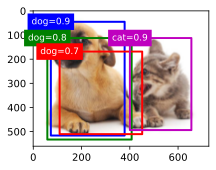

In [ ]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

现在我们可以调用 `multibox_detection` 函数来执行非极大值抑制，其中阈值设置为 0.5。
请注意，我们在示例的张量输入中添加了维度。 

我们可以看到[**返回结果的形状是（批量大小，锚框的数量，6）**]。
最内层维度中的六个元素提供了同一预测边界框的输出信息。
第一个元素是预测的类索引，从 0 开始（0代表狗，1代表猫），值 -1 表示背景或在非极大值抑制中被移除了。
第二个元素是预测的边界框的置信度。
其余四个元素分别是预测边界框左上角和右下角的 $(x, y)$ 轴坐标（范围介于 0 和 1 之间）。


In [ ]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0), nms_threshold=0.5)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

删除 -1 （背景）类的预测边界框后，我们可以[**输出由非极大值抑制保存的最终预测边界框**]。


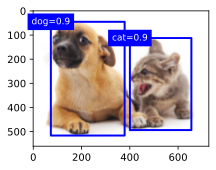

In [ ]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

实践中，在执行非极大值抑制前，我们甚至可以将置信度较低的预测边界框移除，从而减少此算法中的计算量。
我们也可以对非极大值抑制的输出结果进行后处理，例如，只保留置信度更高的结果作为最终输出。


## 小结

* 我们以图像的每个像素为中心生成不同形状的锚框。
* 交并比（IoU）也被称为 Jaccard 指数，用于衡量两个边界框的相似性。它是相交面积与相并面积的比率。
* 在训练集中，我们需要给每个锚框两种类型的标签。一个是与锚框中目标检测的类别，另一个是锚框真实相对于边界框的偏移量。
* 在预测期间，我们可以使用非极大值抑制（NMS）来移除类似的预测边界框，从而简化输出。

## 练习

1. 在 `multibox_prior` 函数中更改 `sizes` 和 `ratios` 的值。生成的锚框有什么变化？
1. 构建并可视化两个 IoU 为 0.5 的边界框。它们是怎样重叠的？
1. 在 :numref:`subsec_labeling-anchor-boxes` 和 :numref:`subsec_predicting-bounding-boxes-nms` 中修改变量 `anchors`，结果如何变化？
1. 非极大值抑制是一种贪婪的算法，它通过 *移除* 来抑制预测的边界框。是否存在一种可能，被移除的一些框实际上是有用的？如何修改这个算法来柔和地抑制 ？你可以参考 Soft-NMS :cite:`Bodla.Singh.Chellappa.ea.2017`。
1. 如果非手动，非最大限度的抑制可以被学习吗？


# 区域卷积神经网络（R-CNN）系列
:label:`sec_rcnn`

除了 :numref:`sec_ssd` 中描述的单发多框检测之外，
区域卷积神经网络（region-based CNN或regions with CNN features，R-CNN） :cite:`Girshick.Donahue.Darrell.ea.2014` 也是将深度模型应用于目标检测的开创性工作之一。
在本节中，我们将介绍R-CNN及其一系列改进方法：快速的R-CNN（Fast R-CNN） :cite:`Girshick.2015` 、更快的R-CNN（Faster R-CNN） :cite:`Ren.He.Girshick.ea.2015` 和掩码R-CNN（Mask R-CNN） :cite:`He.Gkioxari.Dollar.ea.2017` 。
限于篇幅，我们只着重介绍这些模型的设计思路。 

## R-CNN

*R-CNN* 首先从输入图像中选取若干（例如2000个）*提议区域*（如锚框也是一种选取方法），并标注它们的类别和边界框（如偏移量）。 :cite:`Girshick.Donahue.Darrell.ea.2014` 然后，用卷积神经网络对每个提议区域进行前向计算以抽取其特征。
接下来，我们用每个提议区域的特征来预测类别和边界框。 

![R-CNN模型](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/r-cnn.svg?raw=1)
:label:`fig_r-cnn`

:numref:`fig_r-cnn` 展示了R-CNN模型。具体来说，R-CNN包括以下四个步骤： 

1. 对输入图像使用 *选择性搜索* 来选取多个高质量的提议区域 :cite:`Uijlings.Van-De-Sande.Gevers.ea.2013` 。这些提议区域通常是在多个尺度下选取的，并具有不同的形状和大小。每个提议区域都将被标注类别和真实边界框。
1. 选择一个预训练的卷积神经网络，并将其在输出层之前截断。将每个提议区域变形为网络需要的输入尺寸，并通过前向计算输出抽取的提议区域特征。 
1. 将每个提议区域的特征连同其标注的类别作为一个样本。训练多个支持向量机对目标分类，其中每个支持向量机用来判断样本是否属于某一个类别。
1. 将每个提议区域的特征连同其标注的边界框作为一个样本，训练线性回归模型来预测真实边界框。

尽管 R-CNN 模型通过预训练的卷积神经网络有效地抽取了图像特征，但它的速度很慢。
想象一下，我们可能从一张图像中选出上千个提议区域，这需要上千次的卷积神经网络的前向计算来执行目标检测。
这种庞大的计算量使得 R-CNN 在现实世界中难以被广泛应用。 

## Fast R-CNN

R-CNN 的主要性能瓶颈在于，对每个提议区域，卷积神经网络的前向计算是独立的，而没有共享计算。
由于这些区域通常有重叠，独立的特征抽取会导致重复的计算。
*Fast R-CNN* :cite:`Girshick.2015` 对 R-CNN 的主要改进之一，是仅在整张图象上执行卷积神经网络的前向计算。  

![Fast R-CNN模型](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/fast-rcnn.svg?raw=1)
:label:`fig_fast_r-cnn`

:numref:`fig_fast_r-cnn` 中描述了 Fast R-CNN 模型。它的主要计算如下： 

1. 与 R-CNN 相比，Fast R-CNN 用来提取特征的卷积神经网络的输入是整个图像，而不是各个提议区域。此外，这个网络通常会参与训练。设输入为一张图像，将卷积神经网络的输出的形状记为 $1 \times c \times h_1  \times w_1$。
1. 假设选择性搜索生成了$n$个提议区域。这些形状各异的提议区域在卷积神经网络的输出上分别标出了形状各异的兴趣区域。然后，这些感兴趣的区域需要进一步抽取出形状相同的特征（比如指定高度$h_2$和宽度$w_2$），以便于连结后输出。为了实现这一目标，Fast R-CNN 引入了 *兴趣区域 (RoI) 池化* 层：将卷积神经网络的输出和提议区域作为输入，输出连结后的各个提议区域抽取的特征，形状为$n \times c \times h_2 \times w_2$。
1. 通过全连接层将输出形状变换为$n \times d$，其中超参数$d$取决于模型设计。
1. 预测$n$个提议区域中每个区域的类别和边界框。更具体地说，在预测类别和边界框时，将全连接层的输出分别转换为形状为 $n \times q$（$q$ 是类别的数量）的输出和形状为 $n \times 4$ 的输出。其中预测类别时使用 softmax 回归。

在Fast R-CNN 中提出的兴趣区域汇聚层与 :numref:`sec_pooling` 中介绍的汇聚层有所不同。在汇聚层中，我们通过设置池化窗口、填充和步幅的大小来间接控制输出形状。而兴趣区域汇聚层对每个区域的输出形状是可以直接指定的。 

例如，指定每个区域输出的高和宽分别为 $h_2$ 和 $w_2$。
对于任何形状为 $h \times w$ 的兴趣区域窗口，该窗口将被划分为 $h_2 \times w_2$ 子窗口网格，其中每个子窗口的大小约为$(h/h_2) \times (w/w_2)$。
在实践中，任何子窗口的高度和宽度都应向上取整，其中的最大元素作为该子窗口的输出。
因此，兴趣区域汇聚层可从形状各异的兴趣区域中均抽取出形状相同的特征。

作为说明性示例， :numref:`fig_roi` 中提到，在$4 \times 4$的输入中，我们选取了左上角 $3\times 3$ 的兴趣区域。
对于该兴趣区域，我们通过 $2\times 2$ 的兴趣区域汇聚层得到一个 $2\times 2$ 的输出。
请注意，四个划分后的子窗口中分别含有元素 0、1、4、5（5最大）；2、6（6最大）；8、9（9最大）；以及10。 

![一个 $2\times 2$ 的兴趣区域汇聚层](http://d2l.ai/_images/roi.svg)
:label:`fig_roi`

下面，我们演示了兴趣区域汇聚层的计算方法。
假设卷积神经网络抽取的特征 `X` 的高度和宽度都是 4，且只有单通道。


In [ ]:
import torch
import torchvision

X = torch.arange(16.).reshape(1, 1, 4, 4)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

让我们进一步假设输入图像的高度和宽度都是40像素，且选择性搜索在此图像上生成了两个提议区域。
每个区域由5个元素表示：区域目标类别、左上角和右下角的 $(x, y)$ 坐标。


In [ ]:
rois = torch.Tensor([[0, 0, 0, 20, 20], [0, 0, 10, 30, 30]])

由于 `X` 的高和宽是输入图像高和宽的 $1/10$，因此，两个提议区域的坐标先按 `spatial_scale` 乘以 0.1。
然后，在 `X` 上分别标出这两个兴趣区域 `X[:, :, 1:4, 0:4]` 和 `X[:, :, 1:4, 0:4]` 。
最后，在 $2\times 2$ 的兴趣区域汇聚层中，每个兴趣区域被划分为子窗口网格，并进一步抽取相同形状 $2\times 2$ 的特征。


In [ ]:
torchvision.ops.roi_pool(X, rois, output_size=(2, 2), spatial_scale=0.1)

tensor([[[[ 5.,  6.],
          [ 9., 10.]]],


        [[[ 9., 11.],
          [13., 15.]]]])

## Faster R-CNN

为了较精确地检测目标结果，Fast R-CNN 模型通常需要在选择性搜索中生成大量的提议区域。
*Faster R-CNN*  :cite:`Ren.He.Girshick.ea.2015` 提出将选择性搜索替换为 *区域提议网络*（region proposal network），从而减少提议区域的生成数量，并保证目标检测的精度。 

![Faster R-CNN 模型](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/faster-rcnn.svg?raw=1)
:label:`fig_faster_r-cnn`

:numref:`fig_faster_r-cnn` 描述了Faster R-CNN 模型。
与Fast R-CNN 相比，Faster R-CNN 只将生成提议区域的方法从选择性搜索改为了区域提议网络，模型的其余部分保持不变。具体来说，区域提议网络的计算步骤如下： 

1. 使用填充为1的 $3\times 3$ 的卷积层变换卷积神经网络的输出，并将输出通道数记为 $c$。这样，卷积神经网络为图像抽取的特征图中的每个单元均得到一个长度为 $c$ 的新特征。
1. 以特征图的每个像素为中心，生成多个不同大小和宽高比的锚框并标注它们。
1. 使用锚框中心单元长度为 $c$ 的特征，分别预测该锚框的二元类别（含目标还是背景）和边界框。
1. 使用非极大值抑制，从预测类别为目标的预测边界框中移除相似的结果。最终输出的预测边界框即是兴趣区域汇聚层所需的提议区域。

值得一提的是，区域提议网络作为 Faster R-CNN 模型的一部分，是和整个模型一起训练得到的。
换句话说，Faster R-CNN 的目标函数不仅包括目标检测中的类别和边界框预测，还包括区域提议网络中锚框的二元类别和边界框预测。
作为端到端训练的结果，区域提议网络能够学习到如何生成高质量的提议区域，从而在减少了从数据中学习的提议区域的数量的情况下，仍保持目标检测的精度。 

## Mask R-CNN

如果在训练集中还标注了每个目标在图像上的像素级位置，那么 *Mask R-CNN*  :cite:`He.Gkioxari.Dollar.ea.2017` 能够有效地利用这些详尽的标注信息进一步提升目标检测的精度。 

![Mask R-CNN 模型](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/mask-rcnn.svg?raw=1)
:label:`fig_mask_r-cnn`

如 :numref:`fig_mask_r-cnn` 所示，Mask R-CNN 是基于 Faster R-CNN 修改而来的。
具体来说，Mask R-CNN 将兴趣区域汇聚层替换为了
*兴趣区域 (RoI) 对齐* 层，使用 *双线性插值*（bilinear interpolation）来保留特征图上的空间信息，从而更适于像素级预测。
兴趣区域对齐层的输出包含了所有与兴趣区域的形状相同的特征图。
它们不仅被用于预测每个兴趣区域的类别和边界框，还通过额外的全卷积网络预测目标的像素级位置。
本章的后续章节将更详细地介绍如何使用全卷积网络预测图像中像素级的语义。 

## 小结

* R-CNN 对图像选取若干提议区域，使用卷积神经网络对每个提议区域执行前向计算以抽取其特征，然后再用这些特征来预测提议区域的类别和边界框。
* Fast R-CNN 对 R-CNN 的一个主要改进：只对整个图像做卷积神经网络的前向计算。它还引入了兴趣区域汇聚层，从而为具有不同形状的兴趣区域抽取相同形状的特征。
* Faster R-CNN 将 Fast R-CNN 中使用的选择性搜索替换为参与训练的区域提议网络，这样后者可以在减少提议区域数量的情况下仍保证目标检测的精度。
* Mask R-CNN 在 Faster R-CNN 的基础上引入了一个全卷积网络，从而借助目标的像素级位置进一步提升目标检测的精度。

## 练习

1. 我们能否将目标检测视为回归问题（例如预测边界框和类别的概率）？你可以参考 YOLO 模型 :cite:`Redmon.Divvala.Girshick.ea.2016` 的设计。
1. 将单发多框检测与本节介绍的方法进行比较。他们的主要区别是什么？你可以参考 :cite:`Zhao.Zheng.Xu.ea.2019` 中的图2。


[Discussions](https://discuss.d2l.ai/t/2829)
